# Welcome to Lab 3

This is lab 3 of the reinforcement learning. In this lab, you will need to impliment the A2C algorithm, train the agent, and see it in action. Then you will need to write an report on your implimentation.

## Objective

The primary objective of this lab is to familiarize students with the A2C algorithm using basic deep learning libraries, enabling them to improve their capability in transfering mathmatical and theorical knowledge into python implimentation, and further their understanding in actor-critic algorithm.

## Requirements

To participate in this lab, students must have access to a Python programming environment. This canbesetuplocallyusingAnaconda. Alternatively, studentscanuseonlineplatformssuchasGoogle Colab, which provides a ready-to-use environment with access to Python and its libraries without any local setup.


# Actor-Critic Method in Reinforcement Learning

Many successful algorithms in today's reinforcement learning (such as, PPO, SAC, etc) include the idea of dividing into value and advantage.<br>
Now we improve the previous vanilla on-policy learning architecture with this idea and see Actor-Critic architecture intuitively.<br>
In this example, we will explain about Advantage Actor-Critic (shortly, A2C) algorithm.

Actor-Critic is the mixed approach on both value-based Q-Learning method and policy-based method.<br>
As we saw in Q-Learning, it holds $ Q(s_t,a_t) = r_t + \gamma \max_a{Q_t(s_{t+1},a)} $.<br>
As you know, $ \max_a{Q_t(s_{t+1},a)} $ won't depend on action $ a $. Then we can denote $ Q(s_t,a_t) = r_t + \gamma V(s_{t+1}) $ where $ V(s) $ only depends on state $ s $. This $ V(s) $ is called a value-function.

Now we separate $ Q(s_t,a_t) $ into the following two parts :

- one is potential value $ V(s_t) $ not depending on $ a_t $
- the other part is $ A(a_t, s_t) $ (which is called **advantage**) depending on $ a_t $ in state $ s_t $.

Then $ A(a_t, s_t) $ can be written as :

$$ A(a_t, s_t) = r_t + \gamma V(s_{t+1}) - V(s_t) $$

In this method, we generate a value-function (which can also be implemented by neural networks) $ V(s) $ and apply policy gradient for an advantage-function $ A(a, s) $. We should then generate 2 functions - value function and policy function - and optimize parameters in these 2 functions.<br>
Intuitively, the value function is optimized for the value estimation in each state, and the policy function is optimized to take an appropriate action in that state.

Remind that we have applied gradient descent (ascent) on $ E\left[\sum{\gamma r}\right] $ in vanilla on-policy learning. By applying policy gradient on the reduced $ A(a, s) $ instead of $ E\left[\sum{\gamma r}\right] $, we can expect the stable convergence in complex problems, compared with vanilla policy gradient.

For instance, imagine that the reward becomes so large.<br>
In this situation, value will become large, and the value loss will then be larger rather than policy loss.<br>
However, if the network (function) of policy and value are separated, both parameters can be appropriately optimized in the training respectively. (When these are not separated, it could happen that the policy loss will be ignored because it's relatively small, and not optimized enough eventually.)<br>
Even when sharing parameters in the network (function) between value and policy, you can adjust the ratio for policy loss and value loss in Actor-Critic method, and both can then be appropriately optimized.

You can run Actor-Critic-based training on both batch processing and non-batch processing.<br>
For instance, when you run optimization on each episode (as a batch), you can estimate advantage $ A_t $ with $ \sum{\gamma r} - V(s_t) $.<br>
When it's in the middle of episode, you can estimate with $ r_{t} + \gamma r_{t+1} + \cdots + \gamma^{T-1-t} r_{T-1} + \gamma^{T-t} V(s_T) - V(s_t) $.

> Note : This latter approach is known as **temporal difference (TD)** learning, and I don't cover this topic in this repository. (See [GAE (generalized advantage estimation)](https://arxiv.org/pdf/1506.02438) to get generalized advantages between bias and variance in TD learning.)


# Lab Instructions

## Part 1: Algorithm Implementation
### Task 1. **Set Up the Environment**
   - Just like before, we will be using the LunarLander environment.


In [1]:
import gymnasium as gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from collections import deque
import time

# We will be using the LunarLander environment
ENV_NAME = 'LunarLander-v3'
env = gym.make(ENV_NAME)
obs_dim = env.observation_space.shape[0]
n_actions = env.action_space.n


### Task 2. **Understand the A2C Algorithm**
   - Review the theoretical foundations of A2C. (feel free to use any online resources, generative AI tools, etc...)
   - Understand the key components: policy network, value network, advantage estimation, and the actor-critic framework.



### Task 3. **Implement the A2C Algorithm**
   - Create separate networks for the policy (actor) and value (critic).
   - Design the training loop, including:
     - Sampling trajectories from the environment.
     - Computing rewards and advantages.
     - Updating the policy and value networks using gradients.
   - Use appropriate hyperparameters (e.g., learning rates, number of steps, discount factor).


In [2]:
# Setup device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
GAMMA = 0.99
LR_ACTOR = 0.0003
LR_CRITIC = 0.001
MAX_EPISODES = 2000
PRINT_EVERY = 20
ENTROPY_COEF = 0.01
VALUE_COEF = 0.5

# Actor network
class Actor(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(Actor, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        logits = self.net(x)
        return torch.softmax(logits, dim=-1)

# Critic network
class Critic(nn.Module):
    def __init__(self, input_dim):
        super(Critic, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

    def forward(self, x):
        return self.net(x)

# Initialize networks and optimizers
actor_net = Actor(obs_dim, n_actions).to(DEVICE)
critic_net = Critic(obs_dim).to(DEVICE)
actor_optimizer = optim.Adam(actor_net.parameters(), lr=LR_ACTOR)
critic_optimizer = optim.Adam(critic_net.parameters(), lr=LR_CRITIC)

# Function to collect a single episode
def collect_episode(environment, actor_model, critic_model, device):
    observation, _ = environment.reset()
    episode_done = False
    episode_data = {
        'states': [],
        'actions': [],
        'rewards': [],
        'values': [],
        'log_probs': []
    }
    episode_reward = 0

    while not episode_done:
        state_tensor = torch.FloatTensor(observation).to(device)

        # Get action probabilities and state value
        with torch.no_grad():
            action_probs = actor_model(state_tensor)
            value = critic_model(state_tensor).item()

        # Sample action from the probability distribution
        dist = torch.distributions.Categorical(action_probs)
        action = dist.sample()
        log_prob = dist.log_prob(action)

        # Take action in the environment
        next_obs, reward, terminated, truncated, _ = environment.step(action.item())
        episode_done = terminated or truncated

        # Store the transition
        episode_data['states'].append(observation)
        episode_data['actions'].append(action.item())
        episode_data['rewards'].append(reward)
        episode_data['values'].append(value)
        episode_data['log_probs'].append(log_prob.item())

        observation = next_obs
        episode_reward += reward

    return episode_data, episode_reward

# Function to compute returns and advantages
def compute_returns_advantages(episode_data, gamma):
    episode_rewards = episode_data['rewards']
    episode_values = episode_data['values']

    # Calculate returns (discounted sum of rewards)
    episode_returns = []
    R = 0

    for r, v in zip(reversed(episode_rewards), reversed(episode_values)):
        R = r + gamma * R
        episode_returns.insert(0, R)

    episode_returns_tensor = torch.FloatTensor(episode_returns).to(DEVICE)
    episode_values_tensor = torch.FloatTensor(episode_values).to(DEVICE)

    # Calculate advantages
    episode_advantages = episode_returns_tensor - episode_values_tensor

    return episode_returns_tensor, episode_advantages

# A2C update function
def update_networks(actor_model, critic_model, episode_data, actor_opt, critic_opt, entropy_coef, value_coef):
    states_array = np.array(episode_data['states'])
    states_tensor = torch.FloatTensor(states_array).to(DEVICE)
    actions_tensor = torch.LongTensor(episode_data['actions']).to(DEVICE)
    episode_returns, episode_advantages = compute_returns_advantages(episode_data, GAMMA)

    action_probs = actor_model(states_tensor)
    values = critic_model(states_tensor).squeeze()
    dist = torch.distributions.Categorical(action_probs)
    new_log_probs = dist.log_prob(actions_tensor)
    entropy = dist.entropy().mean()

    actor_loss = -(new_log_probs * episode_advantages).mean() - entropy_coef * entropy
    critic_loss = value_coef * ((values - episode_returns) ** 2).mean()

    actor_opt.zero_grad()
    actor_loss.backward()
    torch.nn.utils.clip_grad_norm_(actor_model.parameters(), 0.5)
    actor_opt.step()

    critic_opt.zero_grad()
    critic_loss.backward()
    torch.nn.utils.clip_grad_norm_(critic_model.parameters(), 0.5)
    critic_opt.step()

    return actor_loss.item(), critic_loss.item(), entropy.item()


### Task 4. **Test Your Implementation**
   - Train your A2C agent on LunarLander-v3 environment.
   - Record metrics such as episode rewards and training loss.
   - If you want, try other implementations of A2C and compare with yours. (You may use stablebaselines for this)

Episode 20/2000 | Avg Reward: -170.45 | Actor Loss: -94.0695 | Critic Loss: 2308.5107 | Entropy: 1.3827 | Time: 0.30s
Episode 40/2000 | Avg Reward: -156.65 | Actor Loss: -61.3562 | Critic Loss: 1144.5580 | Entropy: 1.3799 | Time: 0.52s
Episode 60/2000 | Avg Reward: -159.65 | Actor Loss: 45.5989 | Critic Loss: 1131.1167 | Entropy: 1.3815 | Time: 0.77s
Episode 80/2000 | Avg Reward: -160.58 | Actor Loss: -76.7791 | Critic Loss: 1564.4602 | Entropy: 1.3819 | Time: 1.01s
Episode 100/2000 | Avg Reward: -163.55 | Actor Loss: -66.6330 | Critic Loss: 1200.7882 | Entropy: 1.3811 | Time: 1.25s
Episode 120/2000 | Avg Reward: -157.49 | Actor Loss: -67.0817 | Critic Loss: 1252.8086 | Entropy: 1.3795 | Time: 1.50s
Episode 140/2000 | Avg Reward: -173.86 | Actor Loss: -46.4968 | Critic Loss: 591.8131 | Entropy: 1.3817 | Time: 1.74s
Episode 160/2000 | Avg Reward: -188.51 | Actor Loss: -143.2905 | Critic Loss: 5816.9272 | Entropy: 1.3800 | Time: 2.04s
Episode 180/2000 | Avg Reward: -197.96 | Actor Loss: 

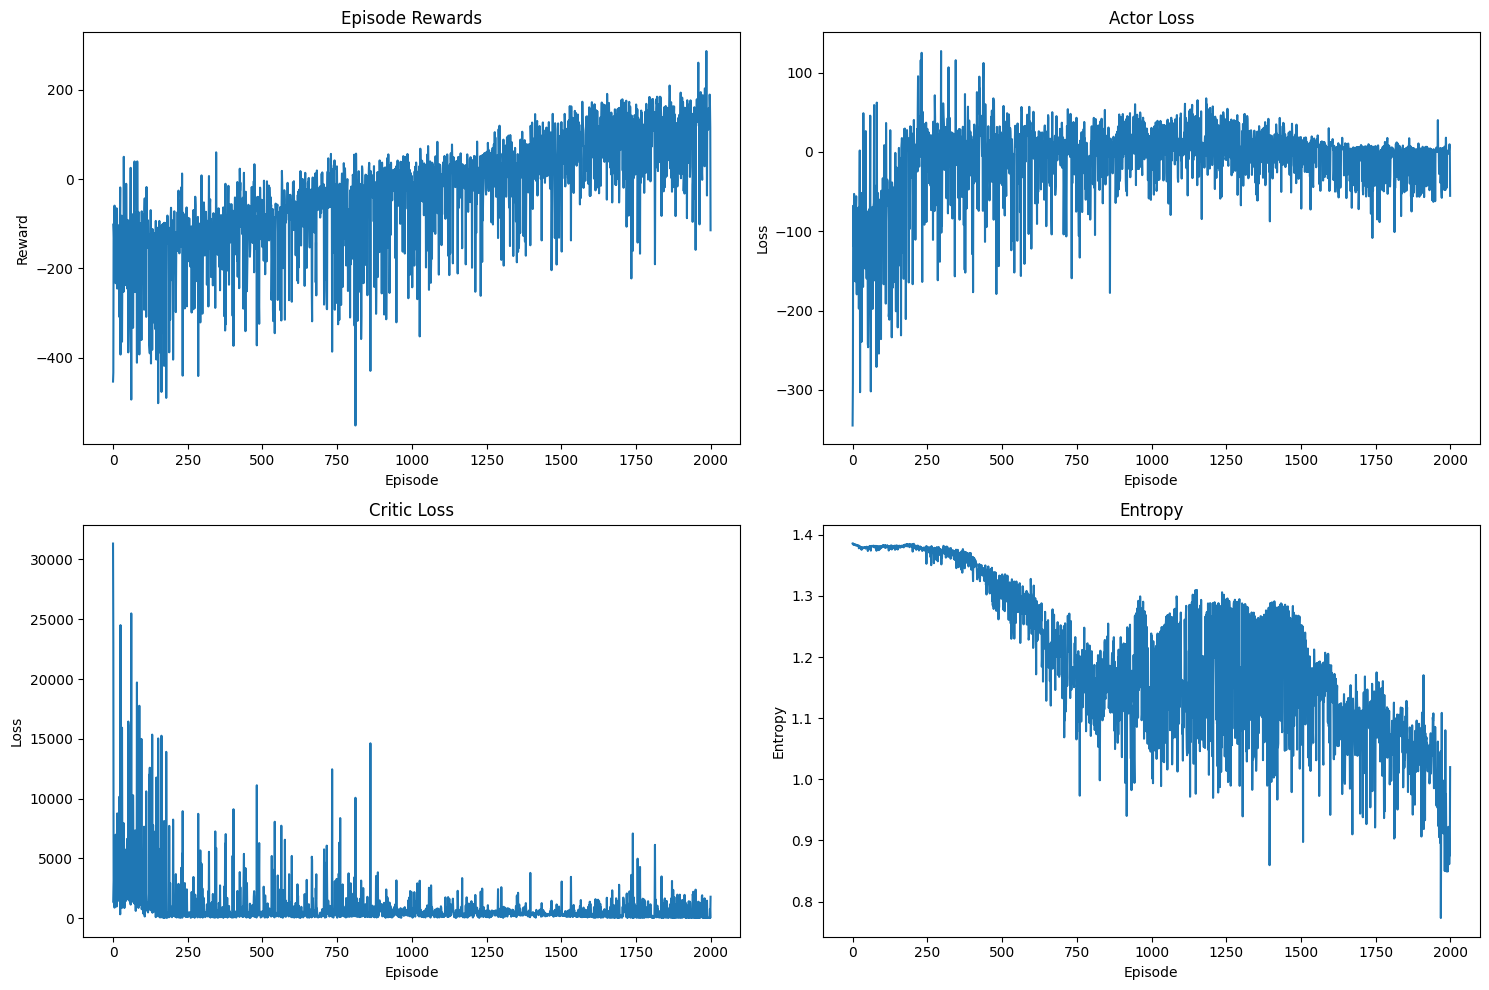

/Users/zr/Code/dts304/venv/lib/python3.10/site-packages/gymnasium/wrappers/rendering.py:283: UserWarning: WARN: Overwriting existing videos at /Users/zr/Code/dts304/dts307/videos folder (try specifying a different `video_folder` for the `RecordVideo` wrapper if this is not desired)
  logger.warn(


Recording episode 1
Episode 1 total reward: 118.33
Recording episode 2
Episode 2 total reward: 195.64
Recording episode 3
Episode 3 total reward: 183.14
Videos saved in ./videos directory


In [3]:
# Training loop
def train_a2c():
    training_rewards = []
    training_actor_losses = []
    training_critic_losses = []
    training_entropy_values = []

    avg_rewards = deque(maxlen=100)

    start_time = time.time()

    for episode_num in range(1, MAX_EPISODES + 1):
        episode_data, episode_reward = collect_episode(env, actor_net, critic_net, DEVICE)

        current_actor_loss, current_critic_loss, current_entropy = update_networks(
            actor_net, critic_net, episode_data,
            actor_optimizer, critic_optimizer,
            ENTROPY_COEF, VALUE_COEF
        )

        training_rewards.append(episode_reward)
        training_actor_losses.append(current_actor_loss)
        training_critic_losses.append(current_critic_loss)
        training_entropy_values.append(current_entropy)
        avg_rewards.append(episode_reward)

        if episode_num % PRINT_EVERY == 0:
            avg_reward = np.mean(avg_rewards)
            elapsed_time = time.time() - start_time
            print(f"Episode {episode_num}/{MAX_EPISODES} | Avg Reward: {avg_reward:.2f} | Actor Loss: {current_actor_loss:.4f} | Critic Loss: {current_critic_loss:.4f} | Entropy: {current_entropy:.4f} | Time: {elapsed_time:.2f}s")

        if len(avg_rewards) == 100 and np.mean(avg_rewards) >= 200:
            print(f"Environment solved in {episode_num} episodes! Average reward: {np.mean(avg_rewards):.2f}")
            break

    return training_rewards, training_actor_losses, training_critic_losses, training_entropy_values

rewards, actor_losses, critic_losses, entropy_values = train_a2c()

plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
plt.plot(rewards)
plt.title('Episode Rewards')
plt.xlabel('Episode')
plt.ylabel('Reward')

plt.subplot(2, 2, 2)
plt.plot(actor_losses)
plt.title('Actor Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.subplot(2, 2, 3)
plt.plot(critic_losses)
plt.title('Critic Loss')
plt.xlabel('Episode')
plt.ylabel('Loss')

plt.subplot(2, 2, 4)
plt.plot(entropy_values)
plt.title('Entropy')
plt.xlabel('Episode')
plt.ylabel('Entropy')

plt.tight_layout()
plt.savefig('a2c_training_results.png')
plt.show()

def record_agent_video(env_name, actor_model, device, n_episodes=3):
    import gymnasium as gym
    from gymnasium.wrappers import RecordVideo
    import os

    # Create videos directory if it doesn't exist
    os.makedirs("./videos", exist_ok=True)

    # Create a video recording environment
    env_record = gym.make(env_name, render_mode="rgb_array")
    env_record = RecordVideo(env_record, video_folder="./videos",
                             episode_trigger=lambda x: True,
                             name_prefix="a2c-agent")

    for i in range(n_episodes):
        observation, _ = env_record.reset()
        episode_done = False
        total_reward = 0

        print(f"Recording episode {i+1}")

        while not episode_done:
            state_tensor = torch.FloatTensor(observation).to(device)
            with torch.no_grad():
                action_probs = actor_model(state_tensor)
            action = torch.argmax(action_probs).item()

            observation, reward, terminated, truncated, _ = env_record.step(action)
            episode_done = terminated or truncated
            total_reward += reward

        print(f"Episode {i+1} total reward: {total_reward:.2f}")

    env_record.close()
    print(f"Videos saved in ./videos directory")

# Save the model and Videos
record_agent_video(ENV_NAME, actor_net, DEVICE)

## Part 2: Write an Report
Write a detailed lab Report covering the following:

1. **Introduction**
   - Briefly describe the A2C algorithm and its significance in reinforcement learning.
   - Mention the task/environment you chose for testing.

2. **Implementation Details**
   - Describe your implementation, including any challenges faced and how you addressed them.
   - Explain the structure of your policy and value networks.
   - Detail the training process and hyperparameters used.

3. **Results and Analysis**
   - Present your results (use graphs for better clarity).
   - Discuss the performance of your agent and any trends observed.
   - Compare your implementation with other implementation. (ie: stable-baselines)

4. **Reflections**
   - Reflect on your experience implementing A2C.
   - Discuss possible improvements or extensions to your implementation.

5. **Conclusion**
   - Summarize key takeaways and insights from the lab.


# End of the Lab

Congratulations!! 🎉🎉🎉 You now reached the end of Lab 3!! 🎉🎉🎉

In this lab, you implemented the A2C algorithm, and completed your lab report, good job!!

Next week, you will be on your own to impliment a new algorithm, best of luck and see you all next week!!
